In [2]:
import matplotlib.pyplot as plt
import spacy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext.vocab as vocab
from torch.utils.data import DataLoader
from torchtext.data import get_tokenizer
from torchtext.datasets import SST2
from torchtext.vocab import build_vocab_from_iterator

nlp = spacy.load("en_core_web_sm")

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
%run models/Linear.ipynb

In [4]:
train_iter = SST2(split="train")
val_iter = SST2(split="dev")

tokenizer = get_tokenizer('spacy')


def yield_tokens(data_iter):
    for text, _ in data_iter:
        yield tokenizer(text)


vocabulary = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocabulary.set_default_index(vocabulary["<unk>"])

D:\Python\Lib\site-packages\torchtext\data\utils.py:105: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(


In [5]:
glove_vectors = vocab.GloVe(name='6B', dim=100)
vocabulary.vectors = glove_vectors.get_vecs_by_tokens(vocabulary.get_itos())

In [6]:
BATCH_SIZE = 128


def collate(x):
    batch = []
    for item in x:
        seq = []
        for word in tokenizer(item[0]):
            seq.append(vocabulary[word])
        batch.append(torch.tensor(seq))
    l = torch.tensor([item[1] for item in x]).unsqueeze(dim=1)
    return nn.utils.rnn.pad_sequence(batch, padding_value=vocabulary["<pad>"], batch_first=True), l


In [7]:
train_loader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=lambda x: collate(x))
val_loader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=lambda x: collate(x))

In [8]:
EMBEDDING_DIM = 100
HIDDEN_DIM = 100
OUTPUT_DIM = 2

model = FC(vocabulary, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)

In [9]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f'The model has {count_parameters(model):,} trainable parameters')
model

The model has 10,302 trainable parameters


FC(
  (embedding): Embedding(13888, 100)
  (fc): Linear(in_features=100, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
  (relu): ReLU()
)

## Train the Model

In [10]:
optimizer = optim.Adam(model.parameters(), lr=5e-3)
criterion = nn.CrossEntropyLoss()
model = model.to(device)
criterion = criterion.to(device)

In [11]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    correct = (preds.argmax(dim=1) == y.argmax(dim=1)).float()  #convert into float for division
    acc = correct.sum() / len(correct)
    return acc

In [12]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    c = 0
    model.train()

    for inputs, labels in iterator:
        c += 1
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        predictions = model(inputs).float()

        targets = F.one_hot(labels.squeeze(), num_classes=2).float()

        loss = criterion(predictions, targets)

        acc = binary_accuracy(predictions, targets)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / c, epoch_acc / c

In [13]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():
        c = 0
        for inputs, labels in iterator:
            c += 1
            inputs = inputs.to(device)
            labels = labels.to(device)

            predictions = model(inputs).float()
            targets = F.one_hot(labels.squeeze().long(), num_classes=2).float()
            loss = criterion(predictions, targets)

            acc = binary_accuracy(predictions, targets)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / c, epoch_acc / c

In [14]:
import time


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [15]:
N_EPOCHS = 20

best_valid_loss = float('inf')

train_losses = []
val_losses = []
train_accuracy = []
val_accuracy = []

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, val_loader, criterion)

    train_losses.append(train_loss)
    train_accuracy.append(train_acc)
    val_losses.append(valid_loss)
    val_accuracy.append(valid_acc)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss > best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'models/fc.pt')

    print(f'Epoch: {epoch + 1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc * 100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc * 100:.2f}%')

Epoch: 01 | Epoch Time: 0m 9s
	Train Loss: 0.472 | Train Acc: 78.00%
	 Val. Loss: 0.508 |  Val. Acc: 76.25%
Epoch: 02 | Epoch Time: 0m 7s
	Train Loss: 0.426 | Train Acc: 80.26%
	 Val. Loss: 0.525 |  Val. Acc: 77.22%
Epoch: 03 | Epoch Time: 0m 9s
	Train Loss: 0.411 | Train Acc: 81.17%
	 Val. Loss: 0.514 |  Val. Acc: 77.11%
Epoch: 04 | Epoch Time: 0m 7s
	Train Loss: 0.397 | Train Acc: 81.94%
	 Val. Loss: 0.531 |  Val. Acc: 74.71%
Epoch: 05 | Epoch Time: 0m 8s
	Train Loss: 0.387 | Train Acc: 82.56%
	 Val. Loss: 0.512 |  Val. Acc: 75.46%
Epoch: 06 | Epoch Time: 0m 8s
	Train Loss: 0.378 | Train Acc: 82.94%
	 Val. Loss: 0.513 |  Val. Acc: 76.52%
Epoch: 07 | Epoch Time: 0m 9s
	Train Loss: 0.366 | Train Acc: 83.50%
	 Val. Loss: 0.500 |  Val. Acc: 77.05%
Epoch: 08 | Epoch Time: 0m 7s
	Train Loss: 0.359 | Train Acc: 83.79%
	 Val. Loss: 0.493 |  Val. Acc: 77.16%
Epoch: 09 | Epoch Time: 0m 8s
	Train Loss: 0.350 | Train Acc: 84.39%
	 Val. Loss: 0.519 |  Val. Acc: 75.46%
Epoch: 10 | Epoch Time: 0m 8

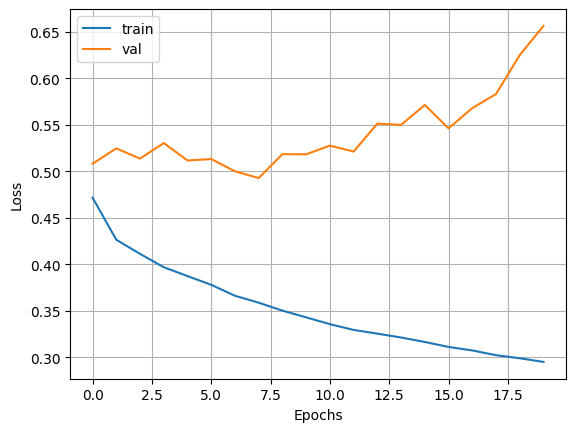

In [16]:
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

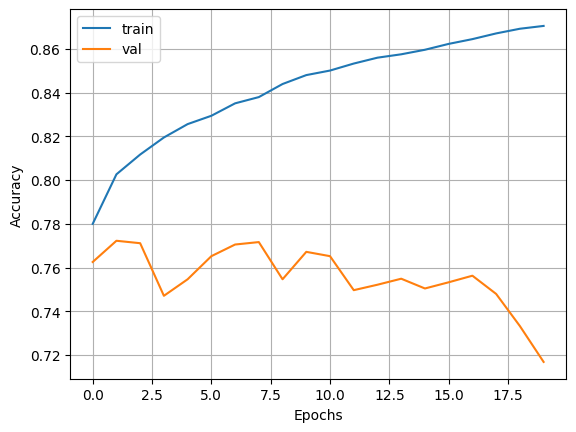

In [17]:
plt.plot(train_accuracy, label='train')
plt.plot(val_accuracy, label='val')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()